In [1]:
import os
from spacy.en import English
import numpy as np

In [2]:
# config
pan15train = "/data/pan15-authorship-verification-training-dataset-english-2015-04-19/"
pan15test = "/data/pan15-authorship-verification-test-dataset2-english-2015-04-19/"
pan14train = "/data/pan14-author-verification-training-corpus-english-essays-2014-04-22/"
pan14test = "/data/pan14-author-verification-test-corpus2-english-essays-2014-04-22/"
char_embeddings_file = "glove.840B.300d-char.txt"  # full path to the character embeddings file

In [3]:
def read_file(filepath):
    with open(filepath) as f:
        s = f.read()
    return s

def load_pan_data(directory, prefix="E"):
    """Load known and unknown texts in the PAN data format"""
    # FIXME: assumes one known file per author, which is fine for English datasets only
    authors = sorted([x for x in os.listdir(directory) if x.startswith(prefix)])
    known_texts = []
    unknown_texts = []
    for author in authors:
        kf = os.path.join(directory, author, "known01.txt")
        uf = os.path.join(directory, author, "unknown.txt")
        known_texts.append(read_file(kf))
        unknown_texts.append(read_file(uf))
        
    truthfile = os.path.join(directory, "truth.txt")
    with open(truthfile) as f:
        lines = f.read().strip().split("\n")
    y = [1 if line.split()[1] == "Y" else 0 for line in lines]
    y = np.array(y)
    return known_texts, unknown_texts, y

def create_pairs(knownX, unknownX):
    print(len(knownX), len(unknownX))
    """Creates pairs of known and unknown texts"""
    pairs = []
    for i in range(len(knownX)):
        pairs += [[knownX[i], unknownX[i]]]
    pairs = np.array(pairs)
    print(pairs.shape)
    return pairs

def vectorize(text, nlp):
    """Convert text (string) to embeddings (numpy array)
    nlp should be an initialised Spacy pipeline with loaded embeddings"""
    return nlp(text, entity=False, tag=False, parse=False).vector

In [4]:
from __future__ import absolute_import
from __future__ import print_function
np.random.seed(1337)  # for reproducibility
import random

from keras.models import Sequential, Model
from keras.layers import Dense, Input, Lambda, Embedding, LSTM, Dropout, Masking, Conv1D, MaxPooling1D
from keras.optimizers import RMSprop
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(64, input_shape=(input_dim,), activation='relu'))
    seq.add(Dense(64, activation='relu'))      
    return seq

def compute_accuracy(predictions, labels):
    return np.mean(np.equal(predictions.ravel() < 0.5, labels))

def train(tr_pairs, tr_y, epochs=20):
    input_dim = tr_pairs.shape[-1]

    # network definition
    base_network = create_base_network(input_dim)

    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))

    # because we re-use the same instance `base_network`,
    # the weights of the network
    # will be shared across the two branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
    model = Model(inputs=[input_a, input_b], outputs=distance)
    
    rms = RMSprop()
    model.compile(loss=contrastive_loss, optimizer=rms)
    model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
              validation_split=0.1,
              batch_size=20,
              epochs=epochs)
    return model
       
def evaluate(model, tr_pairs, tr_y, te_pairs, te_y):
    # compute final accuracy on training and test sets
    pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
    tr_acc = compute_accuracy(pred, tr_y)
    pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
    te_acc = compute_accuracy(pred, te_y)
    print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
    print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))
    
def combine_vectors(v1s, v2s):
    return [np.hstack([v1s[i], v2s[i]]) for i in range(len(v1s))]

Using TensorFlow backend.


In [5]:
known_train, unknown_train, y_train = load_pan_data(pan15train)
known_test, unknown_test, y_test = load_pan_data(pan15test)

In [6]:
y_train[:10]

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0])

In [7]:
import pickle
from sklearn.externals import joblib

classifier = joblib.load("/tmp/pg/output/cwnb.pickle")


with open("/tmp/pg/output/cwvec.pickle", "rb") as f:
    vectorizer = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/pg/output/cwnb.pickle'

In [8]:
def get_relation_vector(text, classifier, vectorizer):
    """Find out how similar a piece of text is to our corpus, sentence by sentence"""
    sentences = text.replace("\n", " ").split(".")
    sentences = [x.strip() for x in sentences]
    print(".")
    textvec = vectorizer.transform(sentences)
    print("vec")
    predictions = classifier.predict_proba(textvec)
    print("cls")
    return predictions
    
    # sum the probability distribution and normalize by number of sentences
    # relation_vector = np.mean(predictions, axis=0)
    # relation_vector /= len(predictions)
    return relation_vector

In [9]:
y_train[:10]

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0])

In [10]:
k1preds = get_relation_vector(known_train[1], classifier, vectorizer)
u1preds = get_relation_vector(unknown_train[1], classifier, vectorizer)

NameError: name 'classifier' is not defined

In [11]:
k0preds = get_relation_vector(known_train[0], classifier, vectorizer)
u0preds = get_relation_vector(unknown_train[0], classifier, vectorizer)

NameError: name 'classifier' is not defined

In [ ]:
k4preds = get_relation_vector(known_train[4], classifier, vectorizer)
u4preds = get_relation_vector(unknown_train[4], classifier, vectorizer)

In [ ]:
[np.argmax(s) for s in k0preds if max(s) > 0.04 and np.argmax(s) != 98]
[np.argmax(s) for s in u0preds if max(s) > 0.04 and np.argmax(s) != 98]

In [ ]:
s1 = set(np.array([np.argpartition(k1preds[i], -5)[-5:] for i in range(len(k1preds))]).flatten())

In [ ]:
s2 = set(np.array([np.argpartition(u1preds[i], -5)[-5:] for i in range(len(u1preds))]).flatten())

In [ ]:
s1.intersection(s2)

In [ ]:
known_rels = [get_relation_vector(t, classifier, vectorizer) for t in known_train]

In [ ]:
unknown_rels = [get_relation_vector(t, classifier, vectorizer) for t in unknown_train]

In [ ]:
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import pearsonr


def minmax(x, y):
    mins, maxs = 0.0, 0.0
    for i in range(x.shape[0]):
        a, b = x[i], y[i]
        if a >= b:
            maxs += a
            mins += b
        else:
            maxs += b
            mins += a
    if maxs > 0.0:
        return 1.0 - (mins / maxs)
    return 0.0

distances = [euclidean(*x) for x in zip(known_rels, unknown_rels)]

In [ ]:
sdists = [known_rels[i] - unknown_rels[i]]

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

clf = SVC()

cross_val_score(clf, distances, y_train)



In [ ]:
from matplotlib import pyplot as plt


same = [x for i, x in enumerate(distances) if y_train[i]]
diff = [x for i, x in enumerate(distances) if not y_train[i]]
print(len(same), len(diff))
plt.scatter(range(len(same)), same)
plt.scatter(range(len(diff)), diff)
plt.show()

In [ ]:
distances[8]

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

nb = MultinomialNB()
vec = TfidfVectorizer()

vec.fit(known_train + unknown_train)

ktrvecs = vec.transform(known_train)
utrvecs = vec.transform(unknown_train)

In [ ]:
fsentences = unknown_train[0].split(".")
fvecs = vec.transform(fsentences)
print(nb.predict(fvecs))

In [ ]:
# del known_train[20]
ktrvecs = vec.transform(known_train)
labels = list(range(100))
del labels[20]
nb.fit(ktrvecs, labels)
print(nb.predict(fvecs))

In [ ]:
known_train[0]

In [ ]:
unknown_train[0]

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 1000

known_train, unknown_train, y_train = load_pan_data(pan15train)
known_test, unknown_test, y_test = load_pan_data(pan15test)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(known_train + unknown_train + known_test + unknown_test)

known_seqs_tr = pad_sequences(tokenizer.texts_to_sequences(known_train), MAX_SEQUENCE_LENGTH)
unknown_seqs_tr = pad_sequences(tokenizer.texts_to_sequences(unknown_train), MAX_SEQUENCE_LENGTH)
known_seqs_te = pad_sequences(tokenizer.texts_to_sequences(known_test), MAX_SEQUENCE_LENGTH)
unknown_seqs_te = pad_sequences(tokenizer.texts_to_sequences(unknown_test), MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
embeddings_index = {}
with open("/data/glove/glove.6B.100d.txt") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

# prepare embedding matrix
EMBEDDING_DIM = 100
num_words = min(MAX_NB_WORDS, len(word_index))
print(num_words)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
known_seqs_tr.shape

In [ ]:
tr_pairs = create_pairs(known_seqs_tr, unknown_seqs_tr)
te_pairs = create_pairs(known_seqs_te, unknown_seqs_te)

In [ ]:
known_train, unknown_train, y_train = load_pan_data(pan15train)
known_test, unknown_test, y_test = load_pan_data(pan15test)
print("word vec...")
# word vectors
w_known_train_vecs = [vectorize(t, nlp_word) for t in known_train]
w_unknown_train_vecs = [vectorize(t, nlp_word) for t in unknown_train]
w_known_test_vecs = [vectorize(t, nlp_word) for t in known_test]
w_unknown_test_vecs = [vectorize(t, nlp_word) for t in unknown_test]
# print("char vec...")
# character vectors
c_known_train_vecs = [vectorize(t, nlp_char) for t in known_train]
c_unknown_train_vecs = [vectorize(t, nlp_char) for t in unknown_train]
c_known_test_vecs = [vectorize(t, nlp_char) for t in known_test]
c_unknown_test_vecs = [vectorize(t, nlp_char) for t in unknown_test]
print("combining...")
# word + character vectors
wc_known_train_vecs = combine_vectors(w_known_train_vecs, c_known_train_vecs)
wc_unknown_train_vecs = combine_vectors(w_unknown_train_vecs, c_unknown_train_vecs)
wc_known_test_vecs = combine_vectors(w_known_test_vecs, c_known_test_vecs)
wc_unknown_test_vecs = combine_vectors(w_unknown_test_vecs, c_unknown_test_vecs)

In [ ]:
def run_experiment(known_train, unknown_train, known_test, unknown_test, y_train, y_test):
    tr_pairs = create_pairs(known_train, unknown_train)
    te_pairs = create_pairs(known_test, unknown_test)
    
    model = train(tr_pairs, y_train)
    evaluate(model, tr_pairs, y_train, te_pairs, y_test)

In [ ]:
model = train(te_pairs, y_test, 5)

In [ ]:
evaluate(model, tr_pairs, y_train, te_pairs, y_test)

In [ ]:
# known_train, unknown_train, y_train = load_pan_data(pan14train)
# known_test, unknown_test, y_test = load_pan_data(pan14test)
run_experiment(known_seqs_te, unknown_seqs_te, known_seqs_tr, unknown_seqs_tr, y_test, y_train)

In [12]:
import os
datadir = "/Users/g/Downloads/Gutenberg/txt/"
files = [x for x in os.listdir(datadir) if x.endswith(".txt")]

texts = []
labels = []

for fname in files:
    with open(os.path.join(datadir,fname), encoding="ISO-8859-1") as f:
        text = f.read()
    texts.append(text)
    labels.append(fname)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

w3vec = TfidfVectorizer(ngram_range=(3,3))

In [ ]:
from datetime import datetime
t1 = datetime.now()
w3vecs = w3vec.fit(texts)
print(datetime.now() - t1)

In [ ]:
w3vecs.shape

In [ ]:
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

cvec = TfidfVectorizer(analyzer='char', ngram_range=(2,4), max_df=4)
wvec = TfidfVectorizer(ngram_range=(1,2), max_df=4)

# rcvec = TfidfVectorizer(analyzer='char', ngram_range=(2,4), max_df=0.01)
# rwvec = TfidfVectorizer(ngram_range=(1,2), max_df=0.01)
vec = FeatureUnion([
    ('cvec', cvec),
    ('wvec', wvec)
])

cls = MultinomialNB(alpha=0.001)

datadir = "/Users/g/Downloads/Gutenberg/txt/sample/"
files = [os.path.join(datadir,fn) for fn in next(os.walk(datadir))[2]]
texts = []
labels = []
for fname in files:
    with open(fname) as f:
        s = f.read()
    texts.append(s)
    labels.append(fname.split("/")[-1])
    

    
# keep = [1,2,5,8,14,17]

# texts = [text for i,text in enumerate(texts) if i in keep]
# labels = [label for i,label in enumerate(labels) if i in keep]


In [ ]:
len(labels)

In [ ]:
vecs = vec.fit_transform(texts)

In [ ]:
vecs.shape

In [ ]:
cls.fit(vecs, labels)

In [452]:
with open("/Users/g/Downloads/Gutenberg/txt/Mark Twain___A Tramp Abroad.txt") as f:
    s = f.read()
    
nvecs = vec.transform([s])

In [453]:
probs = cls.predict_proba(nvecs)[0]

In [454]:
labels

['Alfred Russel Wallace___Island Life.txt',
 'Charles Darwin___The Descent of Man and Selection in Relation to Sex Volume II (1st Edition).txt',
 'Charlotte Bronte___Jane Eyre.txt',
 'Charlotte Mary Yonge___The Trial.txt',
 'D H Lawrence___The Rainbow.txt',
 "Harriet Elizabeth Beecher Stowe___Uncle Tom's Cabin.txt",
 'Henry Rider Haggard___Dawn.txt',
 'James Fenimore Cooper___Mercedes of Castile.txt',
 'Lord Byron___The Works of Lord Byron: Letters and Journals. Vol. 2.txt',
 'Louisa May Alcott___Little Women.txt',
 'Mark Twain___Following the Equator, Complete.txt',
 'Robert Louis Stevenson___The Works of Robert Louis Stevenson - Swanston Edition, Volume 25.txt',
 'Sir Walter Scott___Guy Mannering.txt',
 'Thomas Henry Huxley___Essays Upon Some Controverted Questions.txt',
 'Wilkie Collins___The Moonstone.txt',
 'William Dean Howells___Literature and Life.txt',
 'William Makepeace Thackeray___The History of Henry Esmond, Esq.txt',
 'Winston Churchill___Richard Carvel, Complete.txt']

In [455]:
sorted([(x,i) for i, x in enumerate(probs)], reverse=True)

[(0.99999999199053491, 10),
 (5.3710585658899181e-09, 9),
 (7.5889394292526667e-10, 5),
 (4.7750333688270632e-10, 6),
 (3.2176000164137913e-10, 15),
 (3.0454990246221039e-10, 16),
 (2.1852132071818747e-10, 17),
 (1.6120581024159878e-10, 14),
 (9.6294829881725523e-11, 12),
 (9.3106340646671123e-11, 4),
 (6.5480246425681415e-11, 3),
 (6.281149778646114e-11, 1),
 (4.698160923084154e-11, 0),
 (1.3432248403596974e-11, 2),
 (9.7028625161261614e-12, 11),
 (6.999781416183236e-12, 7),
 (1.1529132404225449e-12, 8),
 (1.9621617448346977e-13, 13)]

In [456]:
def get_probs(text, classifier, vectorizer):
    vecs = vectorizer.transform([text])
    probs = classifier.predict_proba(vecs)
    return probs[0]
    return sorted([(x,i) for i, x in enumerate(probs)], reverse=True)

In [457]:
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import euclidean
corrs = []
pairs = []
for i in range(len(known_train)):
    probs_k = get_probs(known_train[i], cls, vec)
    probs_u = get_probs(unknown_train[i], cls, vec)
    correlation = pearsonr(probs_k, probs_u)[0]
    # correlation = euclidean(probs_k, probs_u)
    corrs.append(correlation)
    pairs.append((probs_k[:], probs_u[:]))

In [458]:
corrs[:10]

[0.19815314915191615,
 0.6946779903948187,
 0.31151294280240333,
 0.067101358003576278,
 0.75778955012574212,
 0.75230073206835435,
 0.72714035783737352,
 -0.24569773997361741,
 0.088672215506988186,
 -0.19869364184115995]

In [459]:
y_train[:10]

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 1])

In [430]:
print(known_train[0])

﻿ English, my English!  
Assesing ones strengths and weaknesses in any situation is a hard task. 
Usually we are not so good at recognizing our strengths, instead we spend our time being critical of ourselves, thus we tend to present a much more detailed side of our flaws. 
I will try to give you a reasonable picture of my good and not quite as good sides, as I see them, in reference to the four skills that were mentioned in the guide-lines handed out earlier in regard of this essay.   y biggest weakness by far is reading in English. 
I most of the time find it quite boring, it probably has to do with the fact that I'm a very outgoing person and therefore I like meeting people and I prefer to converse with them. 
A contributing factor to my feelings about reading also has to do with the fact that I'm just not used to it, which makes reading a bit uncomfortable. 
It takes time to read and it is not by far as fun as actually talking with someone.
You miss out on facial expressions and th

In [431]:
print(pairs[0][0])

﻿ In the name of Religion, you can get away with anything!  
With this argumentative piece I've tried to shed a light on the consequences of religion. 
What goes on, apart from all of the good deeds man does in the name of religion. 
I've devided them in five headings, all regarding different aspects of the topic. 
I myself am not a believer. 
I'm a naturally born critic or sceptic, if you will. 
I firmly believe that it should be up to every man/woman to inividually process information and facts that are given or thrown upon us. 
Just because something has been going on for a long period of time doesn't necessarily mean it's alright.  
1) Religion is prohibiting.  
It compromises the person. 
Religion prevents individual thinking and persuades mankind to accept and "buy the whole concept" of its ideas in the scriptures. 
The scriptures compromise peoples prerogative to think for themselves, they roothlesly rob people of their natural ability to evaluate and act on their own intuition.

In [460]:
get_top_n(pairs[0][0])

[(0.3350353902965163, 15),
 (0.20131051845460246, 4),
 (0.13004367334862393, 9),
 (0.068448876772215714, 5),
 (0.052951978216860505, 2)]

In [461]:
get_top_n(pairs[0][1])

[(0.26263545481161771, 13),
 (0.17495152089484001, 9),
 (0.12145389340008755, 4),
 (0.090082522812767213, 10),
 (0.080364906706658829, 5)]

1

In [195]:
diffs = [(abs(pairs[i][0] - pairs[i][1])) for i in range(len(pairs))]

In [305]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

dtc = LinearSVC()

cross_val_score(dtc, diffs, y_train)

array([ 0.52941176,  0.38235294,  0.5       ])

In [203]:
y_train[:10]

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0])

In [199]:
probs_k = get_probs(known_train[0], cls, vec)
probs_u = get_probs(unknown_train[0], cls, vec)
correlation = pearsonr(probs_k, probs_u)[0]

In [145]:
sorted([(x,i) for i,x in enumerate(probs_k)], reverse=True)[:5]

[(0.26246228675188588, 15),
 (0.18054003355657608, 11),
 (0.13850120787692094, 8),
 (0.094010621134931582, 2),
 (0.087282149361291902, 6)]

In [146]:
sorted([(x,i) for i,x in enumerate(probs_u)], reverse=True)[:5]

[(0.21970686997968397, 8),
 (0.17872084440275832, 5),
 (0.11205463908917677, 6),
 (0.097153017650052964, 2),
 (0.069663401737269259, 15)]

In [159]:
preds = [1 if c > 0.3 else 0 for c in corrs]

In [160]:
from sklearn.metrics import classification_report
print(classification_report(y_train, preds))

             precision    recall  f1-score   support

          0       0.53      0.46      0.49        50
          1       0.53      0.60      0.56        50

avg / total       0.53      0.53      0.53       100



In [161]:
from collections import Counter
Counter(preds)

Counter({0: 43, 1: 57})

In [68]:
y_train

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1])

In [312]:
[(i,x) for i,x in enumerate(cls.classes_)]

[(0, 'Alfred Russel Wallace___Island Life.txt'),
 (1,
  'Charles Darwin___The Descent of Man and Selection in Relation to Sex Volume II (1st Edition).txt'),
 (2, 'Charlotte Bronte___Jane Eyre.txt'),
 (3, 'Charlotte Mary Yonge___The Trial.txt'),
 (4, 'D H Lawrence___The Rainbow.txt'),
 (5, "Harriet Elizabeth Beecher Stowe___Uncle Tom's Cabin.txt"),
 (6, 'Henry Rider Haggard___Dawn.txt'),
 (7, 'James Fenimore Cooper___Mercedes of Castile.txt'),
 (8, 'Lord Byron___The Works of Lord Byron: Letters and Journals. Vol. 2.txt'),
 (9, 'Louisa May Alcott___Little Women.txt'),
 (10, 'Mark Twain___Following the Equator, Complete.txt'),
 (11,
  'Robert Louis Stevenson___The Works of Robert Louis Stevenson - Swanston Edition, Volume 25.txt'),
 (12, 'Sir Walter Scott___Guy Mannering.txt'),
 (13, 'Thomas Henry Huxley___Essays Upon Some Controverted Questions.txt'),
 (14, 'Wilkie Collins___The Moonstone.txt'),
 (15, 'William Dean Howells___Literature and Life.txt'),
 (16, 'William Makepeace Thackeray__

In [344]:
unknown_train[0]

"Oh, he's coming, he's\ncoming. I'm going to get to see Santa Claus! Is it not wonderful? I'm\ngoing to see him. Let me look.  Oh, it's getting\nbigger and _bigger_ and BIGGER!\n\nHurray! daddy's coming! daddy's coming!\n\nNow I can hear the bells. Oh, it's coming closer and _closer_\nand CLOSER. Look out, it's going to hit the boat! \n\nHe flew right by us.\n\nMaybe he didn't see the boat. Oh, now he isn't coming at all.\n\nYes, he is. He's landed right over there. Here he comes; here he comes!\n\nHere we are, Santa Claus. This is the place. Come in. Merry Christmas, Santa Claus, merry Christmas!\n\n\n Hello, there--where are you? It's so dark I can't see a single thing.\n\n Hello, daddy; merry Christmas.\n\n Hello yourself. Merry Christmas to you, too. Are you all ready for me?\n\nYes, it's all ready. The magical tree is just waiting for\nyour touch to turn into a real Christmas tree.\n\n Oh, we're going to have a real Christmas tree.\n\nHello, who's this young person?\n\nThis is Ani

In [327]:
probs = get_probs(known_train[1], cls, vec)

In [328]:
probs

array([  2.63157413e-04,   3.63424003e-04,   1.51173057e-01,
         6.21180572e-02,   8.52935122e-03,   6.66184200e-02,
         2.65660105e-01,   2.51886247e-02,   6.78698750e-02,
         5.72158433e-02,   1.61350919e-02,   4.30569115e-02,
         3.24679580e-02,   2.72565013e-03,   5.16004113e-02,
         1.78756989e-02,   4.89348621e-02,   8.22035010e-02])

In [326]:
get_top_n(probs)

[(0.1805802583148276, 5),
 (0.1231674223073551, 2),
 (0.10326031229216154, 11),
 (0.10009544884921381, 17),
 (0.092155725662713031, 6)]

In [329]:
get_top_n(probs)

[(0.26566010542842122, 6),
 (0.15117305689684615, 2),
 (0.082203501020270964, 17),
 (0.067869875007503841, 8),
 (0.066618420001196957, 5)]

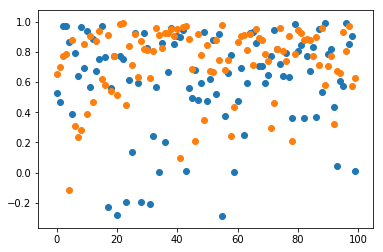

In [416]:
from matplotlib import pyplot as plt
same = [x for i, x in enumerate(corrs) if y_train[i]]
diff = [x for i, x in enumerate(corrs) if not y_train[i]]
plt.scatter(range(len(same)), same)
plt.scatter(range(len(diff)), diff)
plt.show()

In [342]:
pairs[1]

(array([ 0.00029119,  0.00032402,  0.14172081,  0.05993802,  0.01564071,
         0.22899595,  0.13888442,  0.00563165,  0.03284061,  0.14503854,
         0.02050938,  0.0361215 ,  0.01696059,  0.00197749,  0.06005562,
         0.0150772 ,  0.02283913,  0.05715317]),
 array([ 0.00023309,  0.00023881,  0.08496533,  0.11064029,  0.04417158,
         0.14932728,  0.14549685,  0.01243657,  0.01788193,  0.19083817,
         0.0389822 ,  0.04178567,  0.01830458,  0.00146381,  0.0427958 ,
         0.01741076,  0.03006612,  0.05296117]))

In [72]:
probs_k

array([  1.03387574e-03,   1.01290947e-04,   7.45448280e-02,
         1.76205639e-02,   1.96825656e-04,   6.46562669e-02,
         7.47156421e-02,   2.13687540e-02,   2.19551088e-01,
         4.98825978e-02,   6.54541042e-02,   1.90048351e-01,
         2.53348556e-02,   1.12693842e-02,   6.97480964e-02,
         9.99790938e-02,   5.18478541e-03,   9.30959658e-03])

In [73]:
probs_u

array([  1.01881601e-05,   1.80772714e-06,   1.78689765e-01,
         3.39453184e-02,   3.81440424e-04,   8.12189767e-02,
         2.18874760e-01,   6.62441578e-03,   1.41613855e-01,
         6.64314386e-02,   3.85173243e-03,   6.84535453e-02,
         1.91148434e-02,   1.75127143e-04,   2.00912820e-02,
         7.47344561e-03,   2.67276545e-02,   1.26320404e-01])

In [75]:
labels[:20]

[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]

In [76]:
y_train[:20]

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0])

In [77]:
corrs[2]

0.56847087912774141

In [165]:
l = [0]

k1 = [1,2,3]
l[0] = k1
print(l)

k1 = [2,3,4]
print(l)

[[1, 2, 3]]
[[1, 2, 3]]


In [191]:
train(np.array(pairs), y_train, 5)

Train on 90 samples, validate on 10 samples
Epoch 1/5
90/90 [==============================] - 0s - loss: 0.3065 - val_loss: 0.3375
Epoch 2/5
90/90 [==============================] - 0s - loss: 0.2725 - val_loss: 0.3373
Epoch 3/5
90/90 [==============================] - 0s - loss: 0.2562 - val_loss: 0.3404
Epoch 4/5
90/90 [==============================] - 0s - loss: 0.2420 - val_loss: 0.3476
Epoch 5/5
90/90 [==============================] - 0s - loss: 0.2317 - val_loss: 0.3474


In [187]:
np.array(pairs).shape

(100, 2, 18)

In [211]:
def get_top_n(probs, n=5):
    return sorted([(x,i) for i,x in enumerate(probs)], reverse=True)[:n]

In [231]:
get_top_n(pairs[8][0])

[(0.41407982712199759, 8),
 (0.13531089958886042, 5),
 (0.10319671584461411, 16),
 (0.046755954452071098, 11),
 (0.0437303946445722, 12)]

In [232]:
get_top_n(pairs[8][1])

[(0.36099036134327556, 6),
 (0.28744036035580495, 9),
 (0.13028813482730509, 2),
 (0.11534161736975923, 5),
 (0.047291831823309906, 3)]

In [217]:
y_train[:10]

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0])

In [230]:
[(i,x) for i,x in enumerate(cls.classes_)]

[(0, 'Alfred Russel Wallace___Island Life.txt'),
 (1,
  'Charles Darwin___The Descent of Man and Selection in Relation to Sex Volume II (1st Edition).txt'),
 (2, 'Charlotte Bronte___Jane Eyre.txt'),
 (3, 'Charlotte Mary Yonge___The Trial.txt'),
 (4, 'D H Lawrence___The Rainbow.txt'),
 (5, "Harriet Elizabeth Beecher Stowe___Uncle Tom's Cabin.txt"),
 (6, 'Henry Rider Haggard___Dawn.txt'),
 (7, 'James Fenimore Cooper___Mercedes of Castile.txt'),
 (8, 'Lord Byron___The Works of Lord Byron: Letters and Journals. Vol. 2.txt'),
 (9, 'Louisa May Alcott___Little Women.txt'),
 (10, 'Mark Twain___Following the Equator, Complete.txt'),
 (11,
  'Robert Louis Stevenson___The Works of Robert Louis Stevenson - Swanston Edition, Volume 25.txt'),
 (12, 'Sir Walter Scott___Guy Mannering.txt'),
 (13, 'Thomas Henry Huxley___Essays Upon Some Controverted Questions.txt'),
 (14, 'Wilkie Collins___The Moonstone.txt'),
 (15, 'William Dean Howells___Literature and Life.txt'),
 (16, 'William Makepeace Thackeray__

In [239]:
k8 = ' '.join([x.strip() for x in known_train[8].split("\n")])

In [240]:
u8 = ' '.join([x.strip() for x in unknown_train[8].split("\n")])

In [244]:
k8p = get_probs(k8, cls, vec)

In [245]:
u8p = get_probs(u8, cls, vec)

In [247]:
get_top_n(k8p)

[(0.41464804931744725, 8),
 (0.13512633722780415, 5),
 (0.1030241886305906, 16),
 (0.046696272055147647, 11),
 (0.043760428939142546, 12)]

In [248]:
get_top_n(u8p)

[(0.36076764549530133, 6),
 (0.28798015720555897, 9),
 (0.13002743772955924, 2),
 (0.11548080453615225, 5),
 (0.04716723967697755, 3)]